In [5]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
import gstools as gs
import scipy as sc
from models.fno import FNO1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Subsampling rate
sampling_rate = 2
ntrain = 2000
ntest = 200
batch_size = 64

data = np.load("data/grf_data.npy").astype(np.float32)

x_grid = np.linspace(0,20,256)
x_grid_test = np.linspace(10,20,128)
true_func = 2*np.sin(2*x_grid_test)

ValueError: x and y must have same first dimension, but have shapes (256,) and (128,)

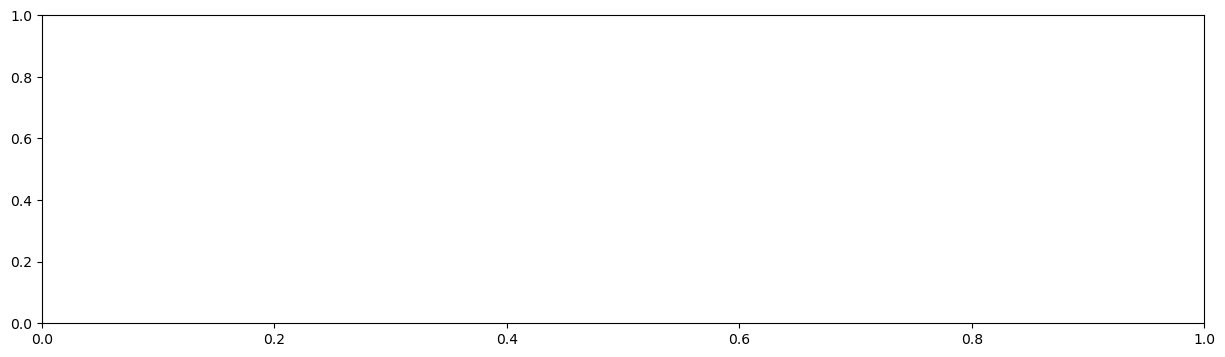

In [7]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(figsize = (15,4))
index = 0
for i in n_samples:
    axs.plot(x_grid,data[i])
    axs.plot(x_grid_test, true_func, color = "black")


axs.grid(True)
axs.margins(0)

In [ ]:
size_x = 128
x_data = torch.tensor(data[:,:size_x])
y_data = torch.tensor(data[:,size_x:])
#y_data = (y_data - y_data.mean()) / y_data.std()


# Add channel dimension
y_data = y_data[:, None, :]
x_data = torch.tensor(np.linspace(-10, 10, size_x), dtype=torch.float).repeat(data.shape[0],1,1)


# Add grid
gridx= torch.tensor(np.linspace(0, 10, size_x), dtype=torch.float)
gridx= gridx.reshape(1, 1, size_x)
x_data = torch.cat((x_data, gridx.repeat([data.shape[0], 1, 1])), dim=1)


x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]


train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [ ]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 20.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 20.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 20
learning_rate = 0.0007
dropout_rate = 0.1

# MC dropout

In [ ]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [ ]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 93537 parameters.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [ ]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-2.2710, Train-MSE-1.8621, Train-L2-0.7548, Test-L2-0.6466
Epoch-1, Time-0.8017, Train-MSE-1.0782, Train-L2-0.5582, Test-L2-0.6282
Epoch-2, Time-0.8201, Train-MSE-1.0517, Train-L2-0.5483, Test-L2-0.6311
Epoch-3, Time-0.8112, Train-MSE-1.0443, Train-L2-0.5473, Test-L2-0.6273
Epoch-4, Time-0.8201, Train-MSE-1.0409, Train-L2-0.5429, Test-L2-0.6340
Epoch-5, Time-0.8110, Train-MSE-1.0327, Train-L2-0.5421, Test-L2-0.6289
Epoch-6, Time-0.8355, Train-MSE-1.0317, Train-L2-0.5431, Test-L2-0.6265
Epoch-7, Time-0.8151, Train-MSE-1.0427, Train-L2-0.5456, Test-L2-0.6302
Epoch-8, Time-0.8196, Train-MSE-1.0278, Train-L2-0.5399, Test-L2-0.6332
Epoch-9, Time-0.8154, Train-MSE-1.0317, Train-L2-0.5417, Test-L2-0.6337
Epoch-10, Time-0.8075, Train-MSE-1.0206, Train-L2-0.5393, Test-L2-0.6324
Epoch-11, Time-0.8157, Train-MSE-1.0259, Train-L2-0.5400, Test-L2-0.6255
Epoch-12, Time-0.8170, Train-MSE-1.0362, Train-L2-0.5417, Test-L2-0.6290
Epoch-13, Time-0.8134, Train-MSE-1.0212, Train-L2-0.5389, Tes

In [ ]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)
dropout_pred = pred

MSE: 0.9239808917045593
ES: 3.7181215286254883


# PFNO

In [ ]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

n_params = count_model_params(sample_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 93537 parameters.


In [ ]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y) #+ variogram_score(out, y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item() #+ variogram_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.0238, Train-L2-0.0819, Test-L2-0.0590
Epoch-1, Time-1.0119, Train-L2-0.0514, Test-L2-0.0556
Epoch-2, Time-1.0578, Train-L2-0.0503, Test-L2-0.0556
Epoch-3, Time-1.1925, Train-L2-0.0497, Test-L2-0.0563
Epoch-4, Time-1.0181, Train-L2-0.0494, Test-L2-0.0555
Epoch-5, Time-1.0130, Train-L2-0.0494, Test-L2-0.0563
Epoch-6, Time-1.0313, Train-L2-0.0498, Test-L2-0.0561
Epoch-7, Time-1.0142, Train-L2-0.0489, Test-L2-0.0556
Epoch-8, Time-1.0331, Train-L2-0.0493, Test-L2-0.0555
Epoch-9, Time-1.0306, Train-L2-0.0491, Test-L2-0.0566
Epoch-10, Time-1.0162, Train-L2-0.0490, Test-L2-0.0564
Epoch-11, Time-1.0150, Train-L2-0.0491, Test-L2-0.0564
Epoch-12, Time-1.0072, Train-L2-0.0492, Test-L2-0.0565
Epoch-13, Time-1.0070, Train-L2-0.0491, Test-L2-0.0565
Epoch-14, Time-1.0084, Train-L2-0.0492, Test-L2-0.0556
Epoch-15, Time-1.0056, Train-L2-0.0491, Test-L2-0.0560
Epoch-16, Time-1.0093, Train-L2-0.0490, Test-L2-0.0555
Epoch-17, Time-1.0144, Train-L2-0.0490, Test-L2-0.0563
Epoch-18, Time-1.033

In [ ]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.9196202754974365
ES: 2.9051766395568848


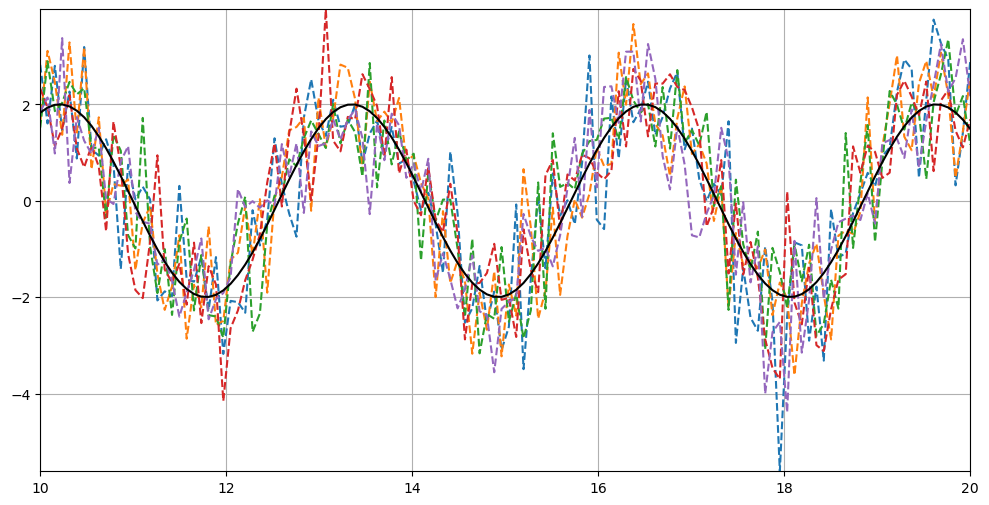

In [ ]:
colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(figsize = (12, 6))
for i, sample in enumerate(np.random.choice(500,5)):
    axs.plot(x_grid_test,pred[0,0,:,sample].cpu().numpy(), '--', label='Prediction')
    index += 1
axs.plot(x_grid_test,true_func, color = "black")

axs.grid(True)
axs.margins(0)

In [ ]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.9239808917045593
ES-Dropout: 3.7181215286254883
MSE: 0.9196202754974365
ES: 2.9051766395568848


# Compare and analyze noise characteristics

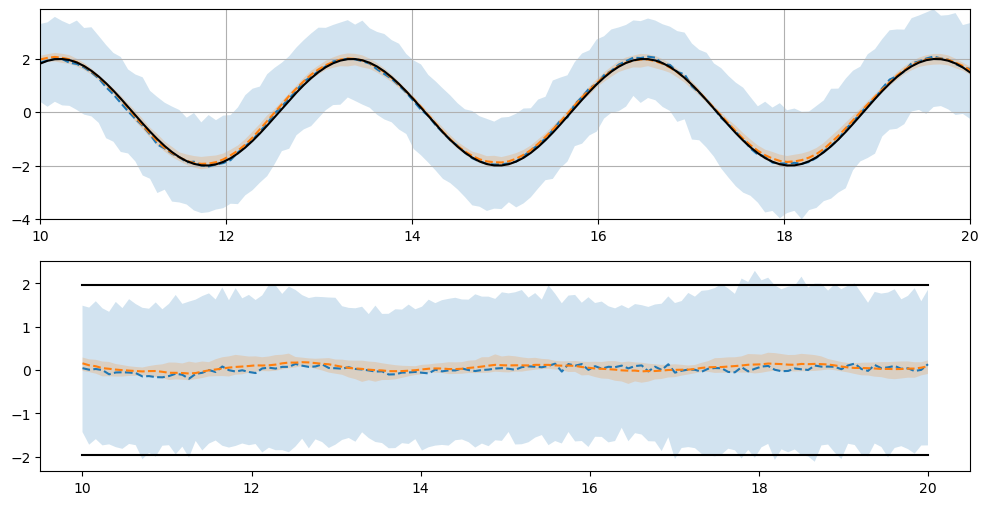

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
i = 0

# Plot PFNO pred
axs[0].plot(x_grid_test,pred[i,0].mean(axis = -1).cpu().numpy(), '--', label='Prediction')
axs[0].fill_between(x_grid_test, pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                    pred[i,0].quantile(0.975, axis = -1).cpu().numpy(), alpha=0.2)
# Plot dropout pred
axs[0].plot(x_grid_test,dropout_pred[i,0].mean(axis = -1).cpu().numpy(), '--', label='Prediction')
axs[0].fill_between(x_grid_test, dropout_pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                dropout_pred[i,0].quantile(0.975, axis = -1).cpu().numpy(), alpha=0.2)
axs[0].plot(x_grid_test,true_func, color = "black")

# Plot Noise only
pfno_noise = pred[i,0].cpu().numpy() - np.expand_dims(true_func,1)
axs[1].plot(x_grid_test,pfno_noise.mean(axis = -1), '--', label='Prediction')
axs[1].fill_between(x_grid_test, np.quantile(pfno_noise,0.025, axis = -1),
                    np.quantile(pfno_noise,0.975, axis = -1), alpha=0.2)


dropout_noise = dropout_pred[i,0].cpu().numpy() - np.expand_dims(true_func,1)
axs[1].plot(x_grid_test,dropout_noise.mean(axis = -1), '--', label='Prediction')
axs[1].fill_between(x_grid_test, np.quantile(dropout_noise,0.025, axis = -1),
                    np.quantile(dropout_noise,0.975, axis = -1), alpha=0.2)

# Plot Gaussian quantile level
axs[1].plot(x_grid_test, np.repeat(sc.stats.norm().ppf(0.025), 128), color = "black")
axs[1].plot(x_grid_test, np.repeat(sc.stats.norm().ppf(0.975), 128), color = "black")

axs[0].grid(True)
axs[0].margins(0)

In [ ]:
pfno_noise.var(axis = 1).mean()

0.7972492007215547

In [ ]:
dropout_noise.var(axis = 1).mean()

0.007647318093611696

# Variogram estimation

In [ ]:
model = gs.Matern(spatial_dim=1, nu = 1, var = 1, len_scale=2)
srf = gs.SRF(model)
bins = np.linspace(0,10,30)

In [ ]:
# Estimate prediction for PFNO
var_samples = 500
pfno_list = [pfno_noise[:,sample] for sample in range(var_samples)]
dropout_list  = [dropout_noise[:,sample] for sample in range(var_samples)]

bin_center_pfno, gamma_pfno = gs.vario_estimate(x_grid_test, pfno_list, bins, mesh_type="structured")
bin_center_dropout, gamma_dropout = gs.vario_estimate(x_grid_test, dropout_list, bins, mesh_type="structured")

# Data estimation
data_list = [y_test[i,0] - true_func for i in range(200)]
bin_center_data, gamma_data= gs.vario_estimate(x_grid_test, data_list, bins, mesh_type="structured")

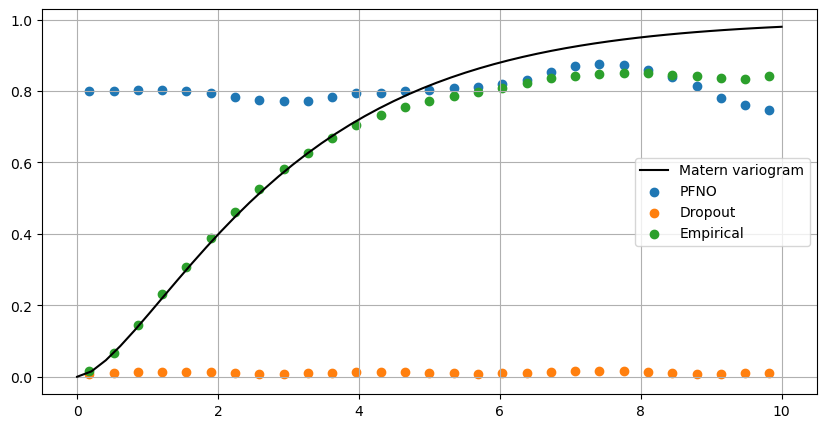

In [ ]:
fig, axs = plt.subplots(figsize = (10,5))
model.plot(x_max=10, ax = axs, color = "black")
axs.scatter(bin_center_pfno, gamma_pfno, label = "PFNO")
axs.scatter(bin_center_dropout, gamma_dropout, label = "Dropout")
axs.scatter(bin_center_data, gamma_data, label = "Empirical")

axs.grid()
axs.legend()